In [7]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.datasets as datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
image_sz = 64
fake_sz = 100

transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root = "./data", train = True, download = True, transform = transform
)

batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 생성자 구성 층 정의
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(fake_sz, 512, kernel_size=4),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x).view(-1, 1)

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [11]:
optim_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999)) # 모멘텀 계수(beta1, beta2)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

criterion = nn.BCELoss()

losses_g = []
losses_d = []

In [14]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_total = (loss_real + loss_fake)/2
    loss_total.backward()
    optimizer.step()
    return loss_total

In [15]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
from torchvision.utils import save_image

In [17]:
epochs = 100
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in enumerate(train_loader):
        image, _ = data
        data_real = image.to(device)
        b_size = len(data_real)
        
        data_fake = generator(torch.randn(b_size, fake_sz, 1, 1).to(device))
        loss_d += train_discriminator(optim_d, data_real, data_fake)

        data_fake = generator(torch.randn(b_size, fake_sz, 1, 1).to(device))
        loss_g += train_generator(optim_g, data_fake)

    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    if epoch%5==0:
        print(f"Epoch {epoch} of {epochs}")
        print(f"Generator loss:{epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
        save_image(data_fake[:25],
                   f'{epoch}.png',
                   nrow = 5,
                   normalize = True)

Epoch 0 of 100
Generator loss:2.69868755, Discriminator loss: 0.27426884
Epoch 5 of 100
Generator loss:3.73200750, Discriminator loss: 0.17345701
Epoch 10 of 100
Generator loss:3.38529706, Discriminator loss: 0.26180300
Epoch 15 of 100
Generator loss:3.95376301, Discriminator loss: 0.13501236
Epoch 20 of 100
Generator loss:3.56519294, Discriminator loss: 0.20520788
Epoch 25 of 100
Generator loss:5.25552225, Discriminator loss: 0.05075011
Epoch 30 of 100
Generator loss:5.96259975, Discriminator loss: 0.00749576
Epoch 35 of 100
Generator loss:3.75406551, Discriminator loss: 0.21927136
Epoch 40 of 100
Generator loss:6.92580080, Discriminator loss: 0.00284429
Epoch 45 of 100
Generator loss:6.95657110, Discriminator loss: 0.00289052
Epoch 50 of 100
Generator loss:5.88022327, Discriminator loss: 0.07074378
Epoch 55 of 100
Generator loss:4.64491844, Discriminator loss: 0.12522459
Epoch 60 of 100
Generator loss:5.42700481, Discriminator loss: 0.05718711
Epoch 65 of 100
Generator loss:4.5793614

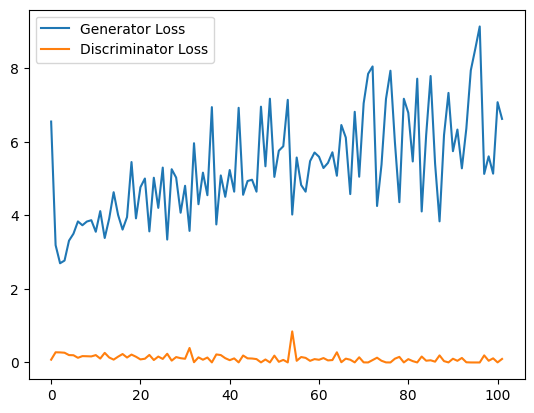

In [19]:
plt.figure()
plt.plot(torch.Tensor(losses_g), label = 'Generator Loss')
plt.plot(torch.Tensor(losses_d), label = 'Discriminator Loss')
plt.legend()